# Import

In [ ]:
# Dataframe
import pandas as pd
import numpy as np

# Logic
import random
import itertools
from scipy.signal import medfilt

# Regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


# Load CSVs

In [3]:
def clean_csv(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    # Step 1: Drop unnecessary columns
    columns_to_drop = ['raw', 'ExperimentTime', 'analysis/ch3_seg_body', 'analysis/ch3_seg_body_str']
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    if 'point_of_death' in df.columns:
        # Propagate 'point_of_death' within each 'Point' group
        df['point_of_death'] = df.groupby('Point')['point_of_death'].transform(lambda x: x.ffill().bfill())

    # Replace NaNs in 'stardist_eggs' column with 0
    df['stardist_eggs'].fillna(0, inplace=True)
    df['csrnet_eggs'].fillna(0, inplace=True)
    
    # Convert 'stardist_eggs' and 'csrnet_eggs' columns to integers
    df['stardist_eggs'] = df['stardist_eggs'].astype(int)
    df['csrnet_eggs'] = df['csrnet_eggs'].astype(int)

    # Step 2: Identify Points to be dropped (where M4 is empty)
    points_dropped = df[df['M4'].isna()]['Point'].unique()
    
    # Step 3: Drop rows where M4 is empty
    df = df[df['M4'].notna()]
    

    # Print the Points that have been dropped
    if len(points_dropped) > 0:
        print(f"Dropped Points due to empty M4: {', '.join(map(str, points_dropped))}")
    else:
        print("No Points were dropped.")

    return df, list(points_dropped)




In [4]:
def load_and_merge_csvs(file_paths):
    df_full = pd.DataFrame()
    dropped_points = list()

    for i, (file_path) in enumerate(file_paths, start = 1):
         
        df = pd.read_csv(file_path)
        df['Point'] = df['Point'] + (i / 10)
        df, dropped = clean_csv(df)
        df = sync_time(df)

        df_full = pd.concat([df_full, df], axis = 0)
        dropped_points.append(dropped)
    
    df_full = df_full.reset_index(drop=True)
    dropped_points = list(itertools.chain(*dropped_points))

    

    return df_full, dropped_points

In [ ]:
def change_eggs_pos(file_path):
    df = pd.read_csv(file_path)
    columns = list(df.columns)
    columns.remove('csrnet_eggs')
    columns.remove('stardist_eggs')

    area_index = columns.index('ch3_seg_body_str_area') + 1
    columns.insert(area_index, 'csrnet_eggs')
    columns.insert(area_index + 1, 'stardist_eggs')

    df = df[columns]

    df.to_csv(f'{file_path[:-4]}_corrected.csv')

    print(f"Saved corrected csv.")




KeyboardInterrupt



# Overall Plots

In [20]:
def overall_plots(df):
    # Check necessary columns
    required_columns = ['Time', 'ch3_seg_body_str_volume', 'ch3_seg_body_str_length', 
                        'ch3_seg_body_str_area', 'csrnet_eggs', 'stardist_eggs']
    for column in required_columns:
        if column not in df.columns:
            raise ValueError(f"The column '{column}' is missing from the DataFrame.")

    # Step 1: Group by Time and calculate averages and standard deviations
    volume_growth = df.groupby('Time')['ch3_seg_body_str_volume'].agg(['mean', 'std', 'count']).reset_index()
    length_growth = df.groupby('Time')['ch3_seg_body_str_length'].agg(['mean', 'std', 'count']).reset_index()
    area_growth = df.groupby('Time')['ch3_seg_body_str_area'].agg(['mean', 'std', 'count']).reset_index()
    egg_counts = df.groupby('Time')[['csrnet_eggs', 'stardist_eggs']].agg(['mean', 'std', 'count']).reset_index()

    # Step 2: Calculate confidence intervals for volume, length, and area
    for growth in [volume_growth, length_growth, area_growth]:
        growth['ci_lower'] = growth['mean'] - 1.96 * (growth['std'] / np.sqrt(growth['count']))
        growth['ci_upper'] = growth['mean'] + 1.96 * (growth['std'] / np.sqrt(growth['count']))

    # Step 3: Plotting
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))

    # Subplot 1: Average Volume, Length, and Area
    axs[0].plot(volume_growth['Time'], volume_growth['mean'], label='Volume', color='blue')  # Volume
    axs[0].fill_between(volume_growth['Time'], volume_growth['ci_lower'], volume_growth['ci_upper'], 
                        color='blue', alpha=0.2)

    axs[0].plot(length_growth['Time'], length_growth['mean'], label='Length', color='green')  # Length
    axs[0].fill_between(length_growth['Time'], length_growth['ci_lower'], length_growth['ci_upper'], 
                        color='green', alpha=0.2)

    axs[0].plot(area_growth['Time'], area_growth['mean'], label='Area', color='orange')  # Area
    axs[0].fill_between(area_growth['Time'], area_growth['ci_lower'], area_growth['ci_upper'], 
                        color='orange', alpha=0.2)

    axs[0].set_xticks(volume_growth['Time'][::50])  # Set x-axis ticks
    axs[0].set_yscale('log')  # Logarithmic scale for y-axis
    axs[0].set_title('Average Growth Over Time')
    axs[0].set_xlabel('Time [hours]')
    axs[0].set_ylabel('Size (Log Scale) [micrometers]')
    axs[0].legend()
    axs[0].grid(True)

    # Subplot 2: Average Egg Counts
    axs[1].plot(egg_counts['Time'], egg_counts['csrnet_eggs']['mean'], label='CSRNet', color='purple')
    axs[1].fill_between(egg_counts['Time'], 
                        egg_counts['csrnet_eggs']['mean'] - 1.96 * (egg_counts['csrnet_eggs']['std'] / np.sqrt(egg_counts['csrnet_eggs']['count'])),
                        egg_counts['csrnet_eggs']['mean'] + 1.96 * (egg_counts['csrnet_eggs']['std'] / np.sqrt(egg_counts['csrnet_eggs']['count'])),
                        color='purple', alpha=0.2)

    axs[1].plot(egg_counts['Time'], egg_counts['stardist_eggs']['mean'], label='StarDist', color='red')
    axs[1].fill_between(egg_counts['Time'], 
                        egg_counts['stardist_eggs']['mean'] - 1.96 * (egg_counts['stardist_eggs']['std'] / np.sqrt(egg_counts['stardist_eggs']['count'])),
                        egg_counts['stardist_eggs']['mean'] + 1.96 * (egg_counts['stardist_eggs']['std'] / np.sqrt(egg_counts['stardist_eggs']['count'])),
                        color='red', alpha=0.2)

    axs[1].set_xticks(egg_counts['Time'][::-50])  # Set x-axis ticks
    axs[1].set_title('Average Egg Count Over Time')
    axs[1].set_xlabel('Time [hours]')
    axs[1].set_ylabel('Egg Counts')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()



# Time Synchronisation and Lifespan evaluation

In [5]:
def sync_time(df):
    df['Time_synced'] = df['Time'] - df['M4']
    df['Death_synced'] = df['point_of_death'] - df['M4']
    return df

def categorise_lifespan(df):
    death_df = df[['Point','point_of_death','Death_synced']]
    # Keep only unique death points
    death_df = death_df.drop_duplicates(subset='Point')

    # Step 2: Group worms by lifespan
    # Define lifespan categories based on quantiles
    quantiles = death_df['Death_synced'].quantile([0.33, 0.66])
    short_living_threshold = quantiles[0.33]
    long_living_threshold = quantiles[0.66]

    death_df['Lifespan_Category'] = None

    for index, row in death_df.iterrows():
        if pd.isna(row['Death_synced']):
            death_df.at[index, 'Lifespan_Category'] = 'unknown'
        elif row['Death_synced'] <= short_living_threshold:
            death_df.at[index, 'Lifespan_Category'] = 'short'
        elif row['Death_synced'] <= long_living_threshold:
            death_df.at[index, 'Lifespan_Category'] = 'medium'
        else:
            death_df.at[index, 'Lifespan_Category'] = 'long'

    df = df.merge(death_df[['Point', 'Lifespan_Category']], on='Point', how='left')

    return df, death_df
    

def plot_death(df):
    # Step 3: Plotting
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Define colors for lifespan categories
    colors = {
        'short': 'red',
        'medium': 'orange',
        'long': 'green',
        'unknown': 'gray'  # For unknown lifespans
    }

    # Histogram for Point of Death
    for category in colors.keys():
        # Get data for the current category
        category_data = df[df['Lifespan_Category'] == category]['point_of_death'].dropna()
        # Plot the histogram bars for the current category
        axs[0].hist(category_data, bins=10, color=colors[category], 
                     edgecolor='black', alpha=0.7, label=category)
    
    axs[0].set_title('Distribution of Worm Lifespan (Point of Death)')
    axs[0].set_xlabel('Point of Death')
    axs[0].set_ylabel('Frequency')
    axs[0].set_xlim(200)
    axs[0].legend()
    axs[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Histogram for Death Synced
    for category in colors.keys():
        # Get data for the current category
        category_data = df[df['Lifespan_Category'] == category]['Death_synced'].dropna()
        # Plot the histogram bars for the current category
        axs[1].hist(category_data, bins=10, color=colors[category], 
                     edgecolor='black', alpha=0.7, label=category)

    axs[1].set_title('Distribution of Worm Lifespan (Point of Death (synced))')
    axs[1].set_xlabel('Point of Death')
    axs[1].set_ylabel('Frequency')
    axs[1].set_xlim(200)
    axs[1].legend()
    axs[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

# Smooth Measurements

In [ ]:
def smooth_measurement(df, column_names, kernel_size=3):
    """
    Apply median filtering to smooth growth measurements over time for each worm (Point).

    Parameters:
    df (pd.DataFrame): DataFrame containing growth measurements.
    column_names (list): List of column names for growth measurements to be smoothed.
    kernel_size (int): Size of the median filter kernel (should be an odd number).

    Returns:
    pd.DataFrame: DataFrame with additional columns for smoothed growth measurements.
    """
    # Ensure the kernel size is valid
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size should be an odd number.")

    # Create a copy of the DataFrame to avoid modifying the original
    df_smoothed = df.copy()

    # Smooth each specified column
    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Column '{column_name}' not found in DataFrame.")

        # Create a list to hold smoothed values
        smoothed_values = {} # Initialize with None to maintain order

        # Group by 'Point'
        for point, group in df.groupby('Point'):
            # Ensure the group is sorted by 'Time' for smoothing
            group_sorted = group.sort_values(by='Time')

            # Apply median filtering to the specific column
            smoothed_group_values = medfilt(group_sorted[column_name].values, kernel_size=kernel_size)

            # Map smoothed values back to their original indices
            for idx, original_index in enumerate(group_sorted.index):
                smoothed_values[original_index] = smoothed_group_values[idx]

        # Assign the smoothed values to the new column in the copy DataFrame
        df_smoothed[f'smoothed_{column_name}'] = smoothed_values

    return df_smoothed





# Get Linear Data Regression on metrics

In [9]:
def get_data_regression(df):    
    # Identify egg columns
    egg_columns = [col for col in df.columns if '_eggs' in col]
    
    # Identify points to remove based on max egg count condition
    points_to_remove = []

    # Iterate over each 'Point' and check if the maximum egg count in any of the egg columns is below 10
    for point, group in df.groupby('Point'):
        # Check the maximum egg count for each egg column in the group
        max_egg_counts = group[egg_columns].max()

        # If any of the egg columns have a max count < 10, mark this point for removal
        if (max_egg_counts < 10).any():
            points_to_remove.append(point)

    # Print points that are removed
    print(f"Points removed due to having max egg count < 10 in any column: {points_to_remove}")

    # Filter the DataFrame to remove the identified points
    df_filtered = df[~df['Point'].isin(points_to_remove)]
    

    def fetch_data_regression(group):
        regressions = {
            'Point': group['Point'].iloc[0],
            'lifespan': group['Death_synced'].iloc[0],
        }  # Initialize with the group key
        
        for column in group.columns:
            min_time = None
            max_time = None
            feature_data = None
            intercept_real = None

            if '_eggs' in column:
                max_point = group[column].max()
                
                min_time = group.loc[(group[column] >= 10), 'Time_synced'].min() - 2
                max_time = min_time + 100
                
            if '_seg_body_str' in column and '_at_' not in column:
                min_time = 0
                max_time = 100
                            
                if 'area' in column or 'volume' in column:
                    # Log-transform the values before regression
                    group[column] = np.log(group[column] + 1e-5)  # Add a small constant to avoid log(0)
       
            if min_time is not None and max_time is not None:
                feature_data = group[(group['Time_synced'] >= min_time) & (group['Time_synced'] <= max_time)][['Time_synced', column]]
                feature_data = feature_data.dropna(subset=[column])
                intercept_real = float(group.loc[group['Time_synced'] >= min_time, column].iloc[0])

            # Only proceed if there's data in the time range
            if feature_data is not None: 
                if not feature_data.empty:
                    X = feature_data['Time_synced'].values.reshape(-1, 1)
                    y = feature_data[column].values
                    
                    # Perform linear regression
                    model = LinearRegression().fit(X, y)
                    regressions.update({
                        f'{column}_times': (min_time, max_time),
                        f'{column}_slope': model.coef_[0],
                        f'{column}_intercept_model': model.intercept_,
                        f'{column}_intercept_real': intercept_real,
                        f'{column}_r_squared': model.score(X, y)
                    })

        return pd.DataFrame([regressions])


    regression_df = df_filtered.groupby('Point', as_index=False).apply(fetch_data_regression).reset_index(drop=True)

    # Filter columns ending with '_slope'
    slope_columns = regression_df.filter(regex=r'_slope$').columns

    # Identify rows where all '_slope' columns have non-negative values
    valid_points = regression_df.loc[(regression_df[slope_columns] >= 0).all(axis=1), 'Point']

    # Identify points to remove: rows where any '_slope' column has a negative value
    removed_points = regression_df.loc[~regression_df['Point'].isin(valid_points), 'Point']
    regression_df_filtered = regression_df[~regression_df['Point'].isin(removed_points)]
    df_filtered = df_filtered[~df_filtered['Point'].isin(removed_points)]

    print("Points with negative values in any '_slope' columns:", removed_points.tolist())
    points_removed = points_to_remove.append(removed_points)

    return regression_df_filtered, df_filtered, points_removed




# Find best multiple regression model

In [11]:
def find_best_model(regression_df):
    # Define strings for smooth vs non-smooth and for the reproduction and growth metrics
    str_list_1 = ['smoothed_', '']
    str_list_2 = ['csrnet', 'stardist']
    str_list_3 = ['area', 'volume']

    # To track the best model
    best_model_info = {
        'combination': None,
        'model_type': None,
        'r_squared': -np.inf,  # Starting with negative infinity for maximization
        'rmse': np.inf,  # Starting with positive infinity for minimization
        'combined_df': None
    }

    # Loop through each combination of smooth/non-smooth, reproduction method, and growth metric
    for str1 in str_list_1:
        for str2 in str_list_2:
            reproduction_str = str1 + str2 + '_eggs'
            
            for str3 in str_list_3:
                growth_str = str1 + 'ch3_seg_body_str_' + str3
                
                # Prepare combined DataFrame for analysis
                combined_df = pd.DataFrame({
                    'Point': regression_df['Point'],
                    'reproduction_rate': regression_df[reproduction_str + '_slope'],
                    'growth_rate': np.exp(regression_df[growth_str + '_slope']),

                    #'size_at_sync_real': regression_df[growth_str + '_intercept_real'],
                    #'eggs_at_sync_real': regression_df[reproduction_str + '_intercept_real'],

                    'lifespan': regression_df['lifespan']
                    
                })
                
                
                combined_df = combined_df.dropna()
                

                # Define X and y
                X = combined_df.drop(['lifespan', 'Point'], axis=1)
                scaler = StandardScaler()
                X = scaler.fit_transform(X)
                y = combined_df['lifespan']

                # Train-test split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                
                ### Multiple Linear Regression

                # Initialize the model
                mlr_model = LinearRegression()

                # Fit the model on the training data
                mlr_model.fit(X_train, y_train)

                # Predict on the test data
                mlr_pred = mlr_model.predict(X_test)

                # Evaluate the model
                mlr_rmse = mean_squared_error(y_test, mlr_pred, squared=False)
                mlr_r2 = r2_score(y_test, mlr_pred)

                ### Random Forest Regressor
                rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
                rf_model.fit(X_train, y_train)
                rf_predictions = rf_model.predict(X_test)

                # Evaluate Random Forest
                rf_r2 = r2_score(y_test, rf_predictions)
                rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)

                ### Gradient Boosting Regressor
                gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
                gb_model.fit(X_train, y_train)
                gb_predictions = gb_model.predict(X_test)

                # Evaluate Gradient Boosting
                gb_r2 = r2_score(y_test, gb_predictions)
                gb_rmse = mean_squared_error(y_test, gb_predictions, squared=False)

                #en_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
                #en_model.fit(X_train, y_train)
                #en_predictions = en_model.predict(X_test)

                # Evaluate ElasticNet
                #en_r2 = r2_score(y_test, en_predictions)
                #en_rmse = mean_squared_error(y_test, en_predictions, squared=False)
                

                # Print results for the current combination
                print(f'Combination: {str1} | {str2} | {str3}')
                print("Multiple Linear Regression:")
                print(f"  R-squared: {mlr_r2:.3f}, RMSE: {mlr_rmse:.3f}")
                print("Random Forest:")
                print(f"  R-squared: {rf_r2:.3f}, RMSE: {rf_rmse:.3f}")
                print("Gradient Boosting:")
                print(f"  R-squared: {gb_r2:.3f}, RMSE: {gb_rmse:.3f}")
                #print("Support Vector Regression:")
                #print(f"  R-squared: {en_r2:.3f}, RMSE: {en_rmse:.3f}")
                print("-" * 50)

                # Check for the best model based on R-squared or RMSE
                for model_type, r2, rmse in [
                    ('Multiple Linear Regression', mlr_r2, mlr_rmse),
                    ('Random Forest', rf_r2, rf_rmse),
                    ('Gradient Boosting', gb_r2, gb_rmse),
                    #('ElasticNet', en_r2, en_rmse),
                ]:
                    if r2 > best_model_info['r_squared']:
                        best_model_info['combination'] = f"{str1} | {str2} | {str3}"
                        best_model_info['model_type'] = model_type
                        best_model_info['r_squared'] = r2
                        best_model_info['rmse'] = rmse
                        best_model_info['combined_df'] = combined_df

    # Print the best model summary
    print("\nBest Model Summary:")
    print(f"Combination: {best_model_info['combination']}")
    print(f"Model Type: {best_model_info['model_type']}")
    print(f"R-squared: {best_model_info['r_squared']:.3f}")
    print(f"RMSE: {best_model_info['rmse']:.3f}")

    return best_model_info




# Get Feature Importance from Model

In [ ]:
def get_feature_importance(best_model_info):
    
    combined_df = best_model_info['combined_df']
    model_type = best_model_info['model_type']
    
    # Define X and y
    X = combined_df.drop(['lifespan', 'Point'], axis=1)
    y = combined_df['lifespan']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if model_type == 'Multiple Linear Regression':
        model = LinearRegression()

        model.fit(X_train, y_train)
        importances = model.coef_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    if model_type == 'Random Forest':
        ### Random Forest Regressor
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        
        model.fit(X_train, y_train)
        
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

    elif model_type == 'Gradient Boosting':
        ### Gradient Boosting Regressor
        model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        
        model.fit(X_train, y_train)
        
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
        
    elif model_type == 'ElasticNet':
        model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
        
        model.fit(X_train, y_train)
        
        importances = model.coef_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
        
        
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df)

    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.show()

    

    # Calculate VIF for each feature
    X_with_const = sm.add_constant(X_train)  # Add constant for VIF calculation
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    # Filter out the constant feature
    vif_data = vif_data[vif_data["Feature"] != "const"]

    corr_df = combined_df.drop(['Point'], axis = 1)
    correlation_matrix = corr_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()

    # Perform K-Fold cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = (-cv_scores)**0.5

    print(f'Cross-Validation RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}')

# MAIN FUNCTION

/tmp/ipykernel_1887147/4028904181.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
/tmp/ipykernel_1887147/4028904181.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['point_of_death'] = df.groupby('Point')['point_of_death'].transform(lambda x: x.ffill().bfill())
/tmp/ipykernel_1887147/4028904181.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method wi

Dropped Points due to empty M4: 9.1, 20.1, 32.1, 35.1, 39.1, 43.1, 49.1


/tmp/ipykernel_1887147/4028904181.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
/tmp/ipykernel_1887147/4028904181.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['point_of_death'] = df.groupby('Point')['point_of_death'].transform(lambda x: x.ffill().bfill())
/tmp/ipykernel_1887147/4028904181.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method wi

Dropped Points due to empty M4: 5.2, 6.2, 11.2, 14.2, 16.2, 17.2, 18.2, 19.2, 20.2, 22.2, 24.2, 25.2, 27.2, 33.2, 34.2, 36.2, 37.2, 38.2, 39.2, 40.2, 41.2, 42.2, 43.2, 44.2, 45.2, 46.2, 47.2, 48.2, 49.2, 50.2, 51.2, 52.2, 53.2, 54.2, 55.2, 56.2, 57.2, 58.2, 59.2, 60.2, 61.2, 62.2, 63.2, 64.2, 65.2, 66.2, 67.2, 68.2, 69.2, 70.2, 71.2, 72.2, 73.2, 74.2, 75.2, 76.2, 77.2, 78.2, 79.2, 80.2, 81.2, 82.2, 83.2, 84.2, 85.2, 86.2, 87.2, 88.2, 89.2, 90.2, 91.2, 92.2, 93.2, 94.2, 95.2, 96.2


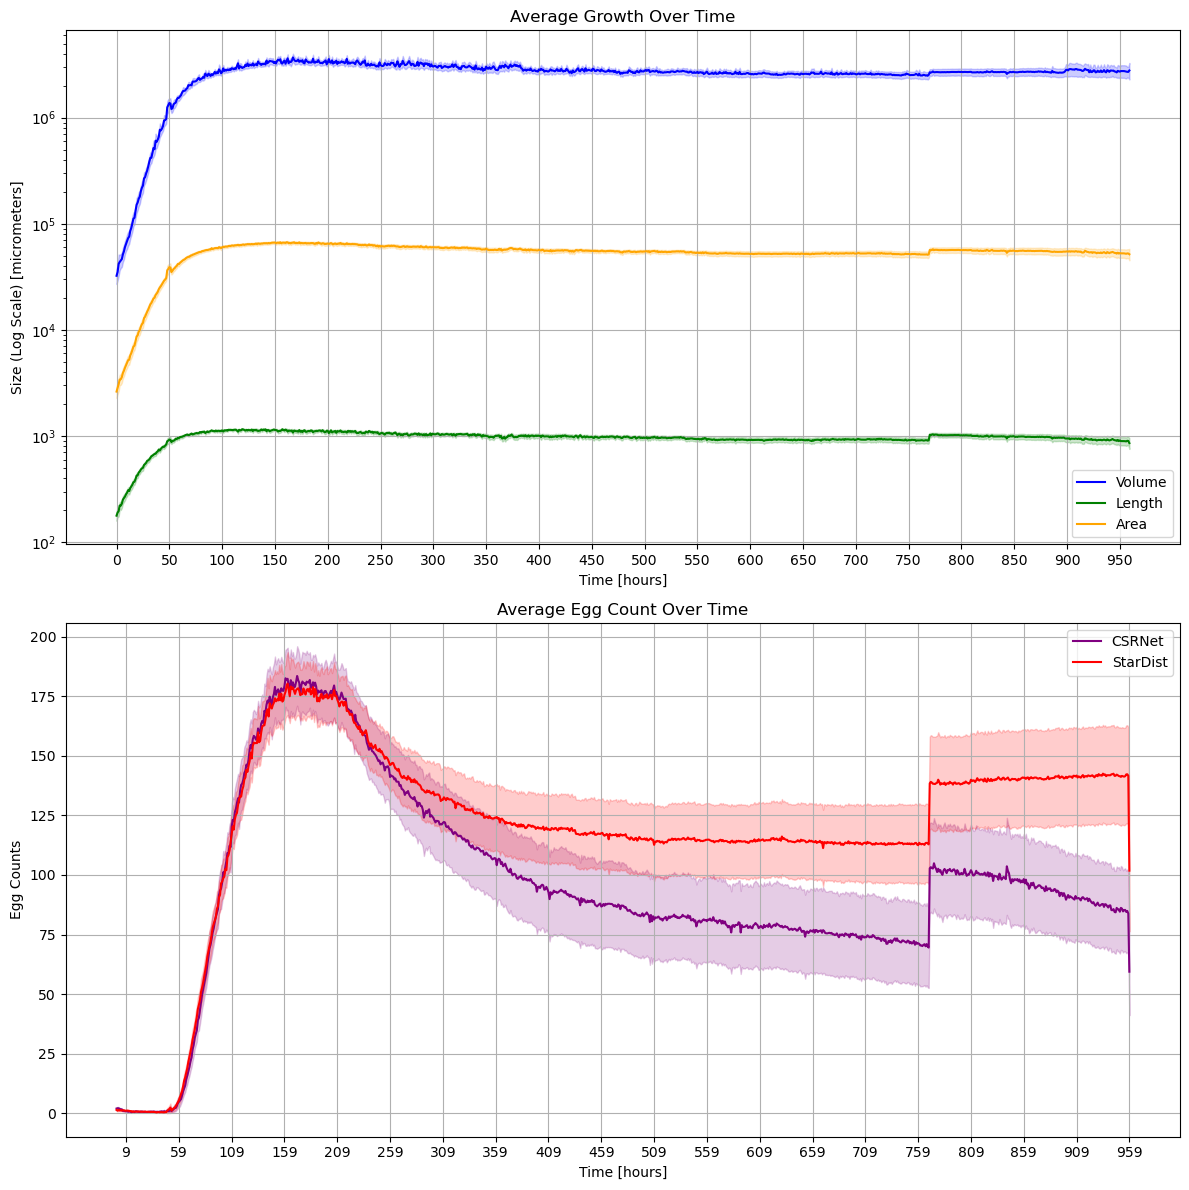

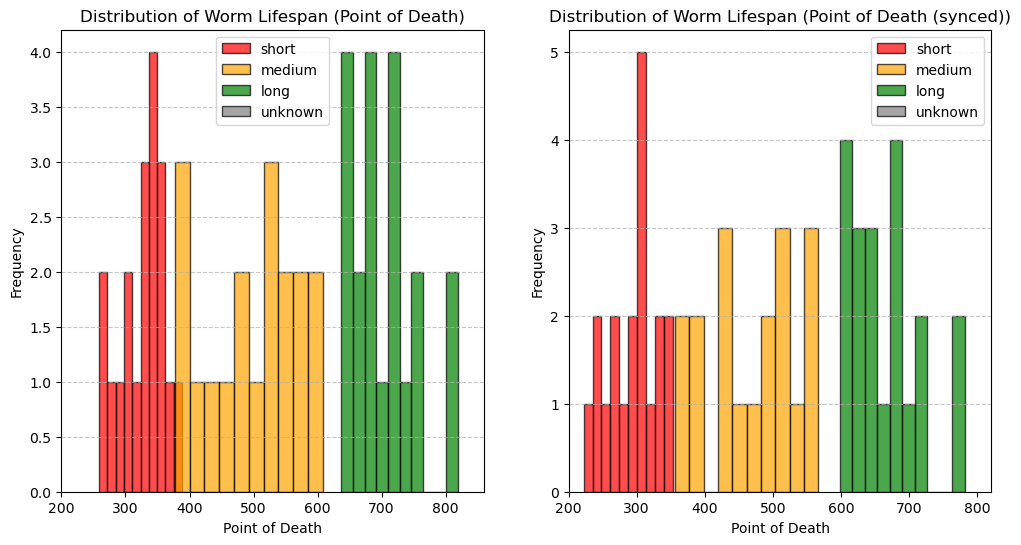

Points removed due to having max egg count < 10 in any column: [6.1]


/tmp/ipykernel_1887147/4015826767.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regression_df = df_filtered.groupby('Point', as_index=False).apply(fetch_data_regression).reset_index(drop=True)
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean sq

Points with negative values in any '_slope' columns: []
    Point  lifespan ch3_seg_body_str_volume_times  \
0     0.1     519.0                      (0, 100)   
1     0.2       NaN                      (0, 100)   
2     1.1     448.0                      (0, 100)   
3     1.2       NaN                      (0, 100)   
4     2.1     436.0                      (0, 100)   
..    ...       ...                           ...   
58   44.1     606.0                      (0, 100)   
59   45.1     629.0                      (0, 100)   
60   46.1     281.0                      (0, 100)   
61   47.1     598.0                      (0, 100)   
62   48.1     766.0                      (0, 100)   

    ch3_seg_body_str_volume_slope  ch3_seg_body_str_volume_intercept_model  \
0                        0.011063                                14.108922   
1                        0.025692                                12.967795   
2                        0.016394                                13.63062

/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is 

Combination: smoothed_ | csrnet | volume
Multiple Linear Regression:
  R-squared: 0.121, RMSE: 147.348
Random Forest:
  R-squared: -0.571, RMSE: 196.919
Gradient Boosting:
  R-squared: -1.386, RMSE: 242.675
--------------------------------------------------
Combination: smoothed_ | stardist | area
Multiple Linear Regression:
  R-squared: 0.012, RMSE: 156.174
Random Forest:
  R-squared: -1.335, RMSE: 240.083
Gradient Boosting:
  R-squared: -2.802, RMSE: 306.368
--------------------------------------------------


/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is 

Combination: smoothed_ | stardist | volume
Multiple Linear Regression:
  R-squared: -0.005, RMSE: 157.549
Random Forest:
  R-squared: -1.188, RMSE: 232.432
Gradient Boosting:
  R-squared: -2.309, RMSE: 285.813
--------------------------------------------------
Combination:  | csrnet | area
Multiple Linear Regression:
  R-squared: 0.111, RMSE: 148.136
Random Forest:
  R-squared: -0.777, RMSE: 209.431
Gradient Boosting:
  R-squared: -2.059, RMSE: 274.810
--------------------------------------------------


/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is 

Combination:  | csrnet | volume
Multiple Linear Regression:
  R-squared: 0.109, RMSE: 148.335
Random Forest:
  R-squared: -0.309, RMSE: 179.770
Gradient Boosting:
  R-squared: -1.031, RMSE: 223.932
--------------------------------------------------
Combination:  | stardist | area
Multiple Linear Regression:
  R-squared: 0.007, RMSE: 156.539
Random Forest:
  R-squared: -1.397, RMSE: 243.275
Gradient Boosting:
  R-squared: -2.491, RMSE: 293.572
--------------------------------------------------
Combination:  | stardist | volume
Multiple Linear Regression:
  R-squared: -0.007, RMSE: 157.659
Random Forest:
  R-squared: -1.097, RMSE: 227.503
Gradient Boosting:
  R-squared: -1.734, RMSE: 259.777
--------------------------------------------------

Best Model Summary:
Combination: smoothed_ | csrnet | area
Model Type: Multiple Linear Regression
R-squared: 0.128
RMSE: 146.726
             Feature    Importance
0  reproduction_rate    -51.155424
1        growth_rate -15704.212626


/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


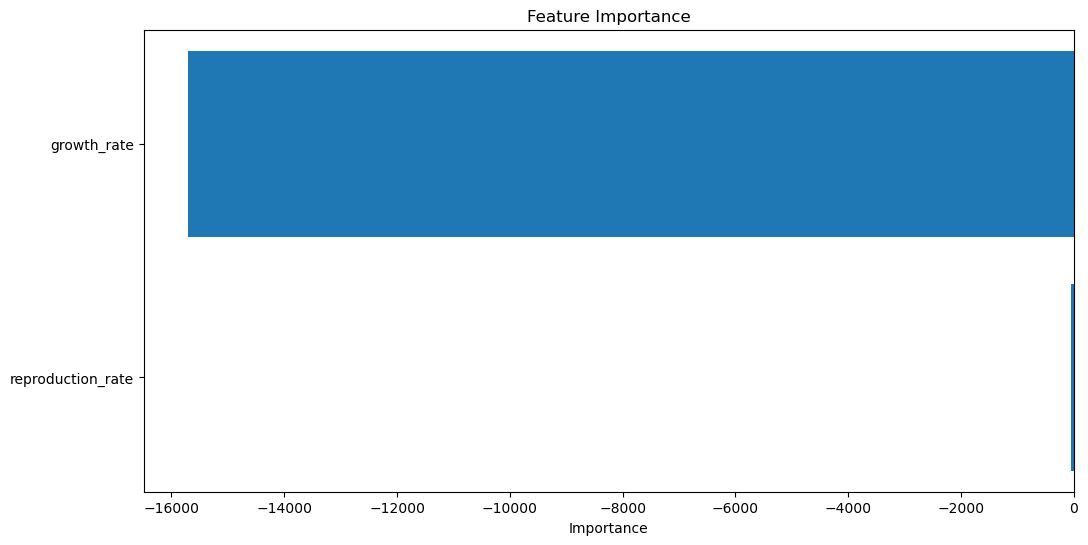

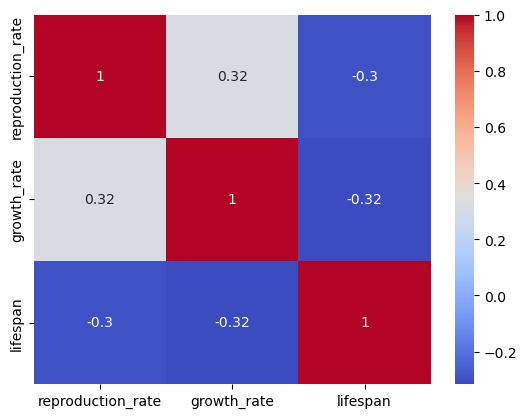

Cross-Validation RMSE: 165.7300771203336 ± 16.55987030432475


In [22]:
def main(file_paths):
    df, dropped = load_and_merge_csvs(file_paths)
    overall_plots(df)
    df = sync_time(df)
    df, death_df = categorise_lifespan(df)
    plot_death(death_df)
    df_smoothed = smooth_measurement(df, ['ch3_seg_body_str_length', 'ch3_seg_body_str_area', 'ch3_seg_body_str_volume', 'stardist_eggs', 'csrnet_eggs'], kernel_size = 25)
    regression_df, df_filtered, points_removed = get_data_regression(df_smoothed)
    print(regression_df)
    dropped.append(points_removed)
    best_model_info = find_best_model(regression_df)
    combined_df = best_model_info['combined_df']
    get_feature_importance(best_model_info)
    return df_filtered, regression_df, combined_df
    
file_paths = ['/mnt/towbin.data/shared/smarin/analysis/2024_02_07_lifespan_wBT318_20C/analysis/report/analysis_filemap_full_corrected.csv', '/mnt/towbin.data/shared/smarin/analysis/lifespan_20240404-20240605/analysis/report/analysis_filemap_corrected_merged_corrected.csv']   
df, regression_df, combined_df = main(file_paths)
    

    
    
    


# Extra Plots

In [ ]:
# Set up the figure with 1 row and 3 columns for violin plots
plt.figure(figsize=(15, 6))

# Violin plot for Growth Rate (with custom x-ticks)
plt.subplot(1, 3, 1)
sns.violinplot(data=stat_df, y='growth_rate', color='red', orient='v')
plt.title('Growth Rate Distribution')
plt.ylabel('Growth Rate')
plt.xlabel('Density')

# Adjust the ticks for growth rate if needed
plt.xticks(rotation=45)  # Rotate the x-ticks to make them readable if needed

# Violin plot for Reproduction Rate
plt.subplot(1, 3, 2)
sns.violinplot(data=stat_df, y='reproduction_rate', color='blue', orient='v')
plt.title('Reproduction Rate Distribution')
plt.ylabel('Reproduction Rate')
plt.xlabel('Density')

# Violin plot for Lifespan
plt.subplot(1, 3, 3)
sns.violinplot(data=stat_df, y='lifespan', color='yellow', orient='v')
plt.title('Lifespan Distribution')
plt.ylabel('Lifespan')
plt.xlabel('Density')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()






/tmp/ipykernel_1278634/332718228.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(0.05, 1.05, f'Equation: y = {model.params[1]:.2f}x + {model.params[0]:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
/tmp/ipykernel_1278634/332718228.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(0.05, 1.05, f'Equation: y = {model.params[1]:.2f}x + {model.params[0]:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
/tmp/ipykernel_1278634/332718228.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alw

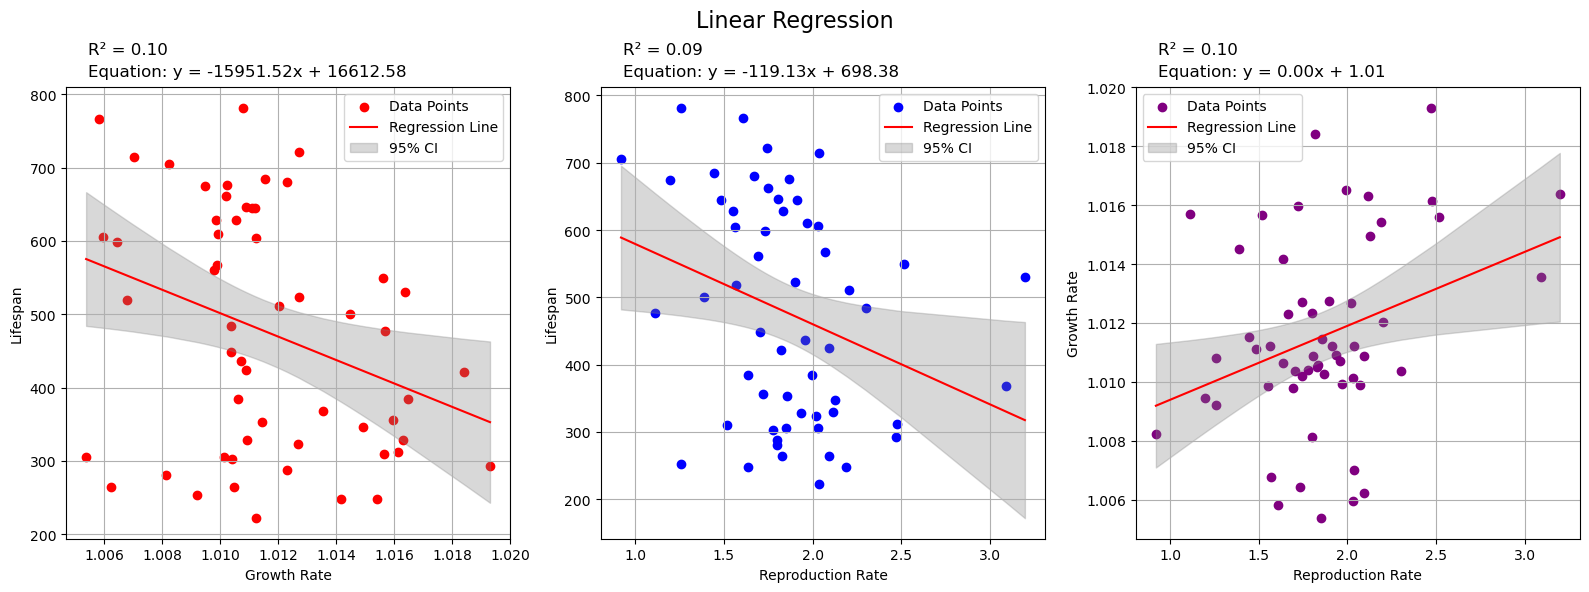

In [ ]:
# Create a single figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Linear Regression', fontsize=16)

# Define a function to plot the regression and confidence intervals
def plot_regression(ax, X, y, color, xlabel, ylabel):
    # Add a constant to the independent variable (for the intercept term)
    X_with_const = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X_with_const).fit()

    # Get the regression line
    y_pred = model.predict(X_with_const)

    # Sort X for a smooth plot
    sorted_X = np.sort(X)
    sorted_X_with_const = sm.add_constant(sorted_X)

    # Get the predicted values for the sorted X values
    sorted_y_pred = model.predict(sorted_X_with_const)

    # Plot the scatter plot and regression line
    ax.scatter(X, y, color=color, label='Data Points')
    ax.plot(sorted_X, sorted_y_pred, color='red', label='Regression Line')

    # Calculate R-squared
    r_squared = model.rsquared
    # Show the R² value on the left plot and the linear regression equation on the right plot
    ax.text(0.05, 1.1, f'R² = {r_squared:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.text(0.05, 1.05, f'Equation: y = {model.params[1]:.2f}x + {model.params[0]:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

    # Get the prediction intervals (95% CI) for sorted X values
    predictions = model.get_prediction(sorted_X_with_const)
    conf_int = predictions.conf_int(alpha=0.05)

    # Plot confidence intervals (shaded region)
    ax.fill_between(sorted_X, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.3, label='95% CI')

    # Label the axes
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()

# Growth Rate vs Lifespan Plot (Position Text 'left' for R-squared)
plot_regression(axs[0], stat_df['growth_rate'], stat_df['lifespan'], color='red', xlabel='Growth Rate', ylabel='Lifespan')

# Reproduction Rate vs Lifespan Plot (Position Text 'right' for Equation)
plot_regression(axs[1], stat_df['reproduction_rate'], stat_df['lifespan'], color='blue', xlabel='Reproduction Rate', ylabel='Lifespan')

plot_regression(axs[2], stat_df['reproduction_rate'], stat_df['growth_rate'], color='purple', xlabel = 'Reproduction Rate', ylabel = 'Growth Rate')

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the title to fit within the figure
plt.show()


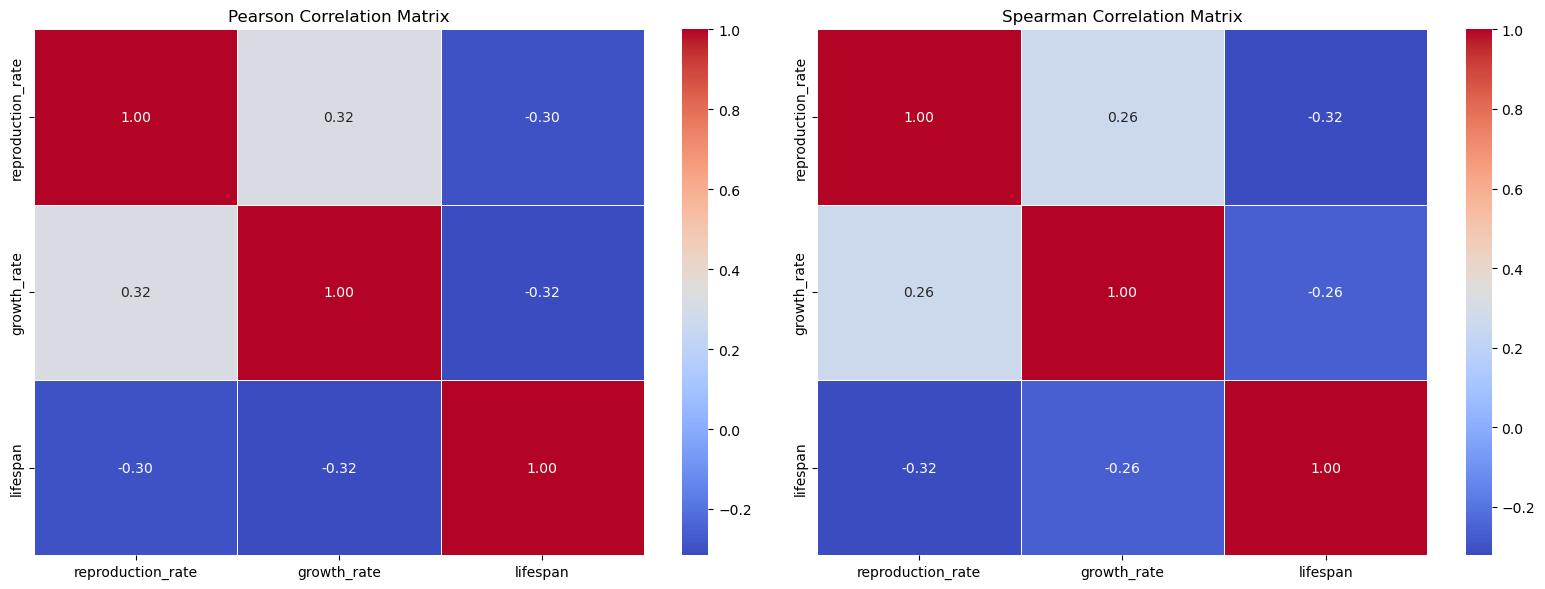

In [62]:
# Calculate Pearson correlation matrix
pearson_corr = stat_df.corr(method='pearson')

# Calculate Spearman correlation matrix
spearman_corr = stat_df.corr(method='spearman')

# Create a single figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the Pearson correlation heatmap
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True, ax=axs[0])
axs[0].set_title('Pearson Correlation Matrix')

# Plot the Spearman correlation heatmap
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True, ax=axs[1])
axs[1].set_title('Spearman Correlation Matrix')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Extra Functions

In [ ]:
def compare_random_worms(df, column, num_worms=3):
    """
    Compare normal and smoothed growth measurements for a specified number of random worms.

    Parameters:
    df (pd.DataFrame): DataFrame containing growth measurements and smoothed values.
    growth_column (str): The column name for the normal growth measurements.
    num_worms (int): The number of random worms to compare.

    Returns:
    None: Displays a plot comparing the normal and smoothed values.
    """
    # Ensure the smoothed column exists
    smoothed_column = f'smoothed_{column}'
    if smoothed_column not in df.columns:
        raise ValueError(f"Column '{smoothed_column}' not found in DataFrame.")
    
    # Get unique Points (Worm IDs)
    worms = df['Point'].unique()
    
    # Select random Points
    random_worm = random.sample(list(worms), num_worms)
    
    # Set up the plotting
    plt.figure(figsize=(12, 8))

    for point in random_worm:
        # Extract normal and smoothed values for the selected Point
        worm_data = df[df['Point'] == point]
        
        # Plot normal values
        plt.plot(worm_data['Time'], worm_data[column], label=f'Normal - Worm {point}', linestyle = 'solid', marker = None)
        # Plot smoothed values
        plt.plot(worm_data['Time'], worm_data[smoothed_column], label=f'Smoothed - Worm {point}', linestyle = '--', marker = None)

    # Adding plot details
    plt.title('Comparison of Normal and Smoothed Measurements')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.grid()
    plt.show()


def plot_all_histograms(df):
    # Select only numeric columns for plotting histograms
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Plot a histogram for each numeric column
    for column in numeric_columns:
        plt.figure(figsize=(4, 3))
        plt.hist(df[column].dropna(), bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()